Let's now take the best result produced by AutoML and get some hands-on experience with it. Also use MLFlow to store the intermediate results. This should give us some idea what to expect.

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_squared_error
from tpot.export_utils import set_param_recursive
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
from IPython.display import HTML
import stars

mlflow.sklearn.autolog()
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment("/mastar/05_manual")


<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='/mastar/05_manual', tags={}>

In [3]:
sl = stars.StarLoader('data/mastarall-v3_1_1-v1_7_7.fits', 'data/mastar-combspec-v3_1_1-v1_7_7-lsfpercent99.5.fits')

In [24]:
goodt = sl.stars[sl.stars['INPUT_TEFF']>0]
mangaid = pd.Series(goodt['MANGAID'].astype('str')).rename('mangaid')
teff = pd.Series(goodt['INPUT_TEFF'].astype('str')).rename('teff')

header = []
for c in np.arange(goodt['FLUX_CORR'].shape[1]):
    header.append('flux%d' % c)
flux_corr = pd.DataFrame(np.array(goodt['FLUX_CORR'].astype(float)), columns=header)

header.append('teff')

df_goodt = pd.concat([mangaid,flux_corr,teff], axis=1)

In [25]:
angstroms = np.array(goodt[0]['WAVE'].astype(float))
hot_id = 61
cold_id = 58

In [181]:
df_goodt.to_parquet('data/goodt_with_mangaid.parquet')

In [26]:
no_mangaid = df_goodt.drop('mangaid', axis=1)
features = no_mangaid.drop('teff', axis=1)

Our crippled TPOT found a Lasso prepended with L2 normalization gave a MSE of around 60,000. This was the best result we've achieved so far.

First an aside to understand what L2 normalizer does with the data. Diagram below shows how different curves get normalized to roughly the same Y range: high curve gets pulled down, and low curve gets pulled up.

This has an effect of discarding information about absolute values, but retaining information about shape.

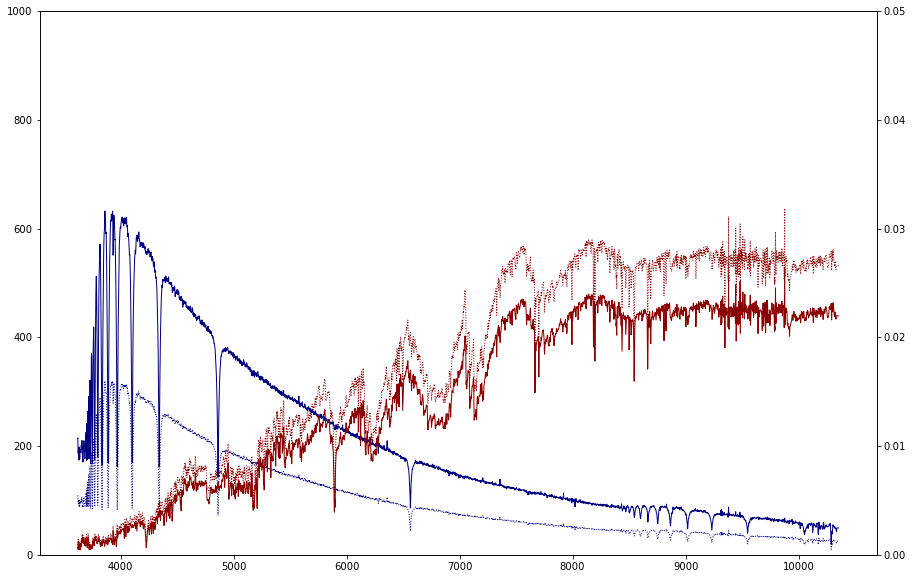

In [27]:
hot = features.iloc[hot_id].astype('float').tolist()
cold = features.iloc[cold_id].astype('float').tolist()

ntest = Normalizer(norm="l2")
ntest.fit(features)
transformed = ntest.transform(features)

fig,ax = plt.subplots(figsize=(15,10))
ax.set_ylim([0,1000])
ax.plot(angstroms, hot, color='navy', linewidth=1, linestyle='dotted')
ax.plot(angstroms, cold, color='darkred', linewidth=1, linestyle='dotted')
ax2 = ax.twinx()
ax2.set_ylim([0,0.05])
ax2.yaxis.tick_right()
ax2.plot(angstroms, transformed[hot_id], color='navy', linewidth=1)
ax2.plot(angstroms, transformed[cold_id], color='darkred', linewidth=1)
plt.show()

After some trial and error, here is a model that gave good results: it gave good MSE (62531.4), while also reducing the largest amount of coefficients (ending up with just 51 key features).

Reducing coefficients is important in a model, because it should reduce bias. Our starting set has more than 4,000 features, and Lasso seems to successfully reduce these to just 51. Overfitting can especially occur because we haven't got too many training examples: around 4,000 as well. Using all coefficients would result in a perfect training fit (with no generalization).

Here is results as recorded by mlflow (metrics have been added as I went, so not all all available everywhere). You can see I started by targeting MSE, but then moved on to minimising coefficients.

|Duration|alpha|max_iter|seed|mse        |non_zero_coef|neg_coef|neg_coef_mag|pos_coef|pos_coef_mag|
|--------|-----|--------|----|-----------|-------------|--------|------------|--------|------------|
|37.8s   |0.01 |10000   |100 |71428.88124|54           |22      |-603694.9406|32      |539525.4721 |
|55.5s   |0.01 |10000   |2   |68172.32194|51           |20      |-611730.219 |31      |560619.3522 |
|44.1s   |0.01 |10000   |1   |62531.37682|51           |18      |-606401.8791|33      |561899.8197 |
|47.2s   |0.01 |10000   |1   |62531.37682|51           |        |            |        |            |
|48.8s   |0.01 |10000   |1   |62531.37682|51           |        |            |        |            |
|1.3min  |0.005|10000   |1   |59086.53159|79           |        |            |        |            |
|18.6min |0.001|100000  |1   |54561.25395|376          |        |            |        |            |
|6.6min  |0.001|30000   |1   |54533.36184|380          |        |            |        |            |
|2.0min  |0.001|10000   |1   |55027.24202|424          |        |            |        |            |
|1.6min  |0.002|10000   |1   |55883.64666|193          |        |            |        |            |
|4.2min  |0.001|20000   |1   |54806.22723|             |        |            |        |            |
|1.8min  |0.001|10000   |1   |55027.24202|             |        |            |        |            |
|42.5s   |0.01 |10000   |1   |62531.37682|             |        |            |        |            |
|16.1s   |0.1  |10000   |1   |115533.2291|             |        |            |        |            |
|7.3s    |10   |10000   |1   |1183756.548|             |        |            |        |            |
|19.2s   |1    |20000   |1   |243477.8778|             |        |            |        |            |

Note I've also tried changing the pipeline to StandardScaler and RobustScaler instead of the Normalizer, but these fared much worse. This leads me to think that the shape matters more than flux magnitudes. This makes sense:

* general knowledge suggests blue stars are hot and red stars are cool (so shape of the spectrum matters)
* magnitude of the spectrum depends on the distance, not only on temperature (so since the distance is unknown, and uncorrected for, this may as well be a random scaling factor)

One way where the model could be better off including magnitude (not normalising), would be if it found a way to predict star distance from the spectral data (which is technically possible based on red-shift measurements of the absorption lines). This way the algorithm could correct for the distance, and actually use the magnitudes as well as spectral shape. The fact that the model produced poor results without normalisation seems to mean that Lasso is unable to make that connection. Perhaps a neural net could?

The diagram of the non-zero coefficients follows the histogram in this result.

In [33]:
seed = 1
training_features_all, testing_features_all, training_target, testing_target = train_test_split(df_goodt, df_goodt['teff'], random_state=seed)

mangaid_training = training_features_all['mangaid']
mangaid_testing = testing_features_all['mangaid']
training_features = np.array(training_features_all.drop(['mangaid', 'teff'], axis=1))
testing_features = np.array(testing_features_all.drop(['mangaid', 'teff'], axis=1))

[Pipeline] ........ (step 1 of 2) Processing normalizer, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=  35.7s
MSE: 62531.37


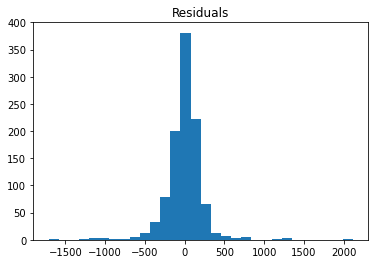

Non-zero coefficients: 51


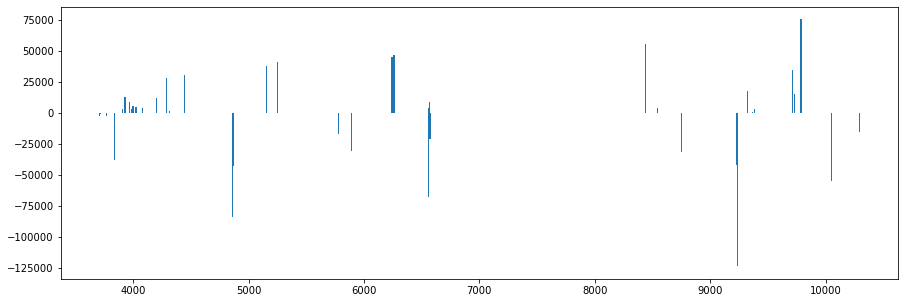

Positive coefficients: 33
Positive coef magnitude: 561899
Negative coefficients: 18
Positive coef magnitude: -606401


In [34]:
            
with mlflow.start_run(run_name='norml2-lasso'):
    alpha=0.01
    max_iter=10000.0

    lasso = Lasso(alpha=alpha, max_iter=max_iter)
    pipeline = make_pipeline(
        Normalizer(norm="l2"),
        lasso,
        verbose=True
    )
    set_param_recursive(pipeline.steps, 'random_state', seed)

    pipeline.fit(training_features, training_target)

    results = pipeline.predict(testing_features)
    mse = mean_squared_error(testing_target, results)
    print('MSE: %.2f' % mse)
    residuals = np.array(testing_target).astype('float') - results
    plt.title('Residuals')
    plt.hist(residuals, bins=30)
    plt.savefig('artifacts/05_hist.png')
    plt.show()

    coef = pd.DataFrame(zip(angstroms, lasso.coef_))
    coef = coef[coef[1]!=0]
    print("Non-zero coefficients: %d" % len(coef))
    fig,ax = plt.subplots(figsize=(15,5))
    ax.bar(coef[0], coef[1], width=10)
    plt.savefig('artifacts/05_coef.png')
    plt.show()

    pos_coef = len(coef[coef[1]>0])
    pos_coef_mag = float(coef[coef[1]>0][1].sum())
    neg_coef = len(coef[coef[1]<0][1])
    neg_coef_mag = float(coef[coef[1]<0][1].sum())
    print('Positive coefficients: %d' % pos_coef)
    print('Positive coef magnitude: %d' % pos_coef_mag)
    print('Negative coefficients: %d' % neg_coef)
    print('Positive coef magnitude: %d' % neg_coef_mag)

    mlflow.log_artifact('artifacts/05_hist.png')
    mlflow.log_artifact('artifacts/05_coef.png')
    mlflow.log_metric("non_zero_coef", len(coef))
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("pos_coef", pos_coef)
    mlflow.log_metric("pos_coef_mag", pos_coef_mag)
    mlflow.log_metric("neg_coef", neg_coef)
    mlflow.log_metric("neg_coef_mag", neg_coef_mag)
    #mlflow.sklearn.log_model(pipeline, "model")

These coefficients look oddly specific - and they look similar regardless of the random seed used (checked 1,2 and 100).

This leads me to wonder if these coefficients are discovering absorption lines. This shouldn't be, because absorption lines can be red- or blue-shifted, but maybe I'm misunderstanding the data (perhaps this is redshift-corrected?). Or perhaps the exact positioning of the absorption lines doesn't matter?

Let's compare the coefficients with the earlier spectra.

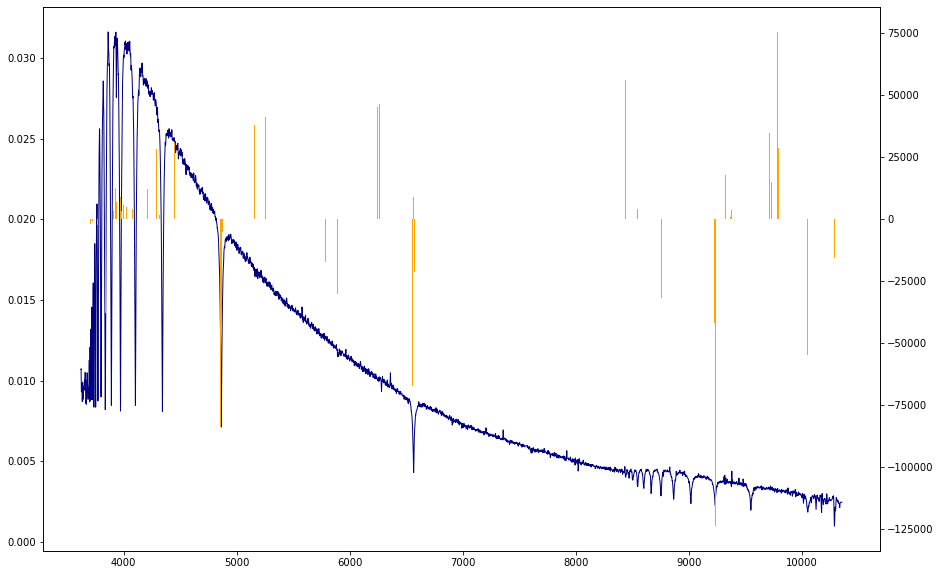

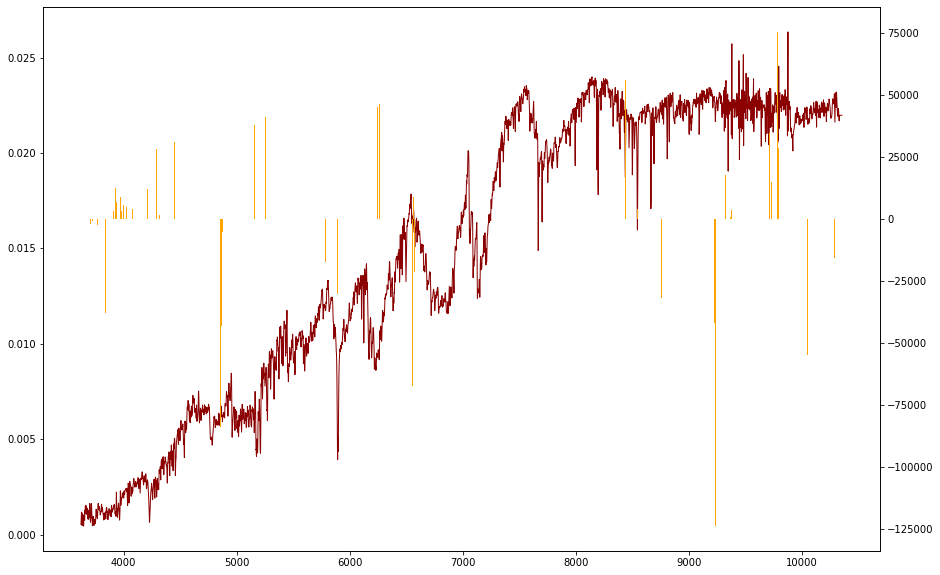

In [35]:
fig,ax = plt.subplots(figsize=(15,10))
ax.plot(angstroms, transformed[hot_id], color='navy', linewidth=1)
ax2 = ax.twinx()
ax2.yaxis.tick_right()
ax2.bar(coef[0], coef[1], color='orange', width=10)
plt.show()

fig,ax = plt.subplots(figsize=(15,10))
ax.plot(angstroms, transformed[cold_id], color='darkred', linewidth=1)
ax2 = ax.twinx()
ax2.yaxis.tick_right()
ax2.bar(coef[0], coef[1], color='orange', width=10)
plt.show()

Ok, wow, this is uncanny - it's easy to find spectra with absorption lines matching coefficients almost exactly - and this is regardless of the random seed used. Not all match, but on most spectra at least some do, especially on blue stars. I take this to mean the algorithm is at least partly deciding based on spectral lines.

It's hard to judge whether it's also using the shape, but I feel like left side of the spectrum (blue, hot stars) has more positive coefficients, and right side has more negative coefficients (red, cold stars).

I think it's likely the algorithm is opportunistically using both techniques, but it somewhat works even if it misses spectral lines. For example look at the lines at 6500Å and 9200Å: they are a high-magnitude negative coefficients, where the following is true:

* due to typical spectrum shape, cold red stars tend to have higher spectral values here than hot blue stars (which pulls predicted temperature down for red stars)
* hot blue stars tend to have an absorption line in that exact spot (which pushes the predicted temperature up for blue stars - negative coefficient gets multiplied by very low flux value)

It would be interesting to run the same model on spectra with absorption lines removed to see what results we get. For example we could average flux values  into bins. Would the result be just as good? If it was shape that mattered, the result should be just as good.

Another angle would be to get the worst-performing examples, and see if they are the ones with mismatch between the positioning of coefficients and absorption lines, or perhaps with unexpected match.

Could the model even find the absorption lines? Previously I've assumed not - I was assuming the stars in our galaxy would show enough redshift to render all absorption-line based predictions useless. Is this true though?

Doing [a bit of googling](https://physics.stackexchange.com/a/186446), it seems the most extreme sun-relative velocities in our galaxy would be in order of 400km/s. Based on this [calculator](https://www.omnicalculator.com/physics/redshift), a redshift of 1nm (10Å) would signify a z of 0.0015152 - fraction of speed of light - which is around around 454 km/s. So then a maximum redshift to expect in our dataset would be around 1nm.

Let's take a hydrogen absorption line at 656.3nm and see how many flux data samples cover the range of 656.3nm ±1nm.

In [36]:
np_ang = np.array(angstroms)
np_ang[(np_ang>=6553) & (np_ang<=6573)]

array([ 6553.90285833,  6555.41212399,  6556.92173721,  6558.43169807,
        6559.94200665,  6561.45266303,  6562.96366729,  6564.47501952,
        6565.98671978,  6567.49876817,  6569.01116476,  6570.52390964,
        6572.03700287])

13 samples cover the hydrogen absorption line. However on star spectra, absorption line is not a line - it's a dip that spans multiple samples as visible in the "hot" star spectrum pictured above. Let's have a look how many samples are covered, and also overlay where the coefficients are.

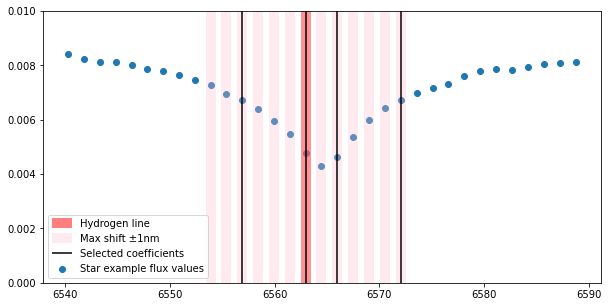

2578   -67363.358700
2582     4387.885236
2584     8814.818652
2588   -21070.137709
Name: 1, dtype: float64


In [37]:
df_ang = pd.DataFrame([angstroms, transformed[hot_id]]).transpose()
h_line = df_ang[(df_ang[0]>=6540) & (df_ang[0]<=6590)]

fig,ax = plt.subplots(figsize=(10,5))
ax.vlines(6563.0, ymin=0.0, ymax=0.01, color='red', label='Hydrogen line', linewidth=10, alpha=0.5)
ax.vlines(np_ang[(np_ang>=6553) & (np_ang<=6573)], ymin=0.0, ymax=0.01, color='pink', label='Max shift ±1nm', linewidth=10, alpha=0.3)
ax.vlines(coef[0][(coef[0]>=6540) & (coef[0]<=6590)], ymin=0.0, ymax=0.01, color='black', label='Selected coefficients')
ax.scatter(h_line[0], h_line[1], label='Star example flux values')
ax.legend()
ax.set_ylim([0.0, 0.01])
plt.show()

print(coef[1][(coef[0]>=6540) & (coef[0]<=6590)])

We can see from the chart above, that the model has selected multiple coefficients to cover this absorption line. Clearly the model is trying to capture a range of values. The values of the coefficients remind me of an double-sided edge-detection kernel.

Here is an interpretation of how the prediction value changes as the trough moves through the values. We sweep the abosrption line (first chart) through the coefficients, changing the trough between -16 and 16 samples. The prediction contribution is shown in green in the second chart.

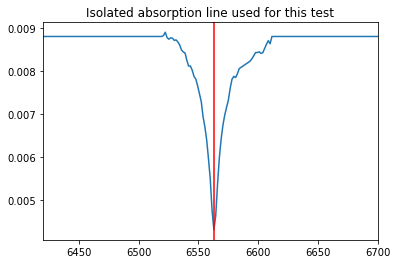

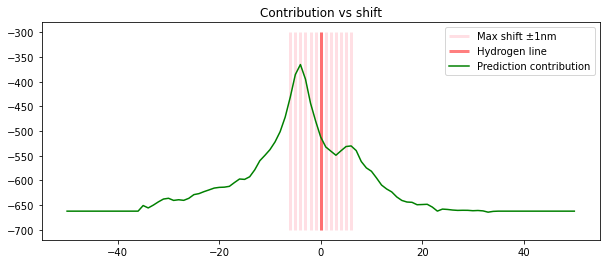

In [38]:
cs = coef[(coef[0]>=6553) & (coef[0]<=6573)]
def apply_transform(samples):
    masked = samples[samples.index.isin(cs.index)]
    return (cs[1]*masked[1]).sum()

# Shift by -1 to return the trough to 6563, and zero everything outside of the line
samples = df_ang.copy()
samples[1] = samples[1].shift(-1)
samples[1][(samples[0]<=6520) | (samples[0]>=6610)] = 0.0088

plt.plot(samples[0], samples[1])
plt.axvline(6563.0, color='red')
plt.title('Isolated absorption line used for this test')
plt.xlim(6420, 6700)
plt.show()

# Walk the line back and forth through coefficients
rs = []
for shift in np.arange(-50, 51):
    shifted = samples.copy()
    shifted[1] = shifted[1].shift(shift)
    rs.append(apply_transform(shifted))

fig,ax = plt.subplots(figsize=(10,4))
ax.vlines(np.arange(-6, 7), ymin=-700, ymax=-300, color='pink', label='Max shift ±1nm', linewidth=3, alpha=0.5)
ax.vlines(0, ymin=-700, ymax=-300, color='red', label='Hydrogen line', linewidth=3, alpha=0.5)
ax.plot(np.arange(-50, 51), rs, label='Prediction contribution', color='green')
plt.legend()
plt.title('Contribution vs shift')
plt.show()

Baseline result for these coefficients is around -650. A trough at hydrogen absortpion line, or at nearby locations can produce a result of almost -350, contributing up to 300K to the final prediction.

I think this proves this model is capturing the absorption lines, and that it is resilient to speed differences of up to 400km/s.

My interpretation of coefficients is that the outer coefficients set the limits to how far the line can be shifted. These sit close to my esimated 1nm boundaries. Inner coefficients serve to flatten the middle of the result, removing extreme spiking that would otherwise result in the centre. Essentially, these coefficients are trying to produce a trapezoidal result (a plateau) covering all possible redshifts.

This result persists over different random seeds too. Seed=2 produces a much more balanced plateau (with this one, seed=1, being somewhat skewed to the left.)

Let's now have a look at testing examples where the model made the worst mistakes, and try to derive the reasons. This could help us understand if we have constructed the wrong model.

Prediction distance - K below target Teff
               0
811  2115.336469
786  2011.169147
425  1328.475605
596  1324.770790
359  1243.180658


MANGAID,Image,Spectrum,Input T,Input source
3-153089223,,,7840K,SEGUE
7-7454891,,,8033K,SEGUE
3-119686885,,,5152K,LAMOST_CANNON
3-117543154,,,5096K,LAMOST_CANNON
7-13115756,,,3690K,APOGEE

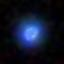
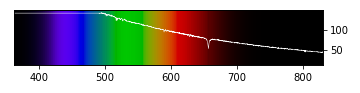
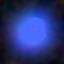
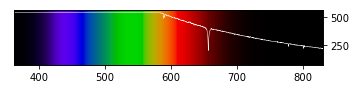
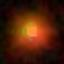
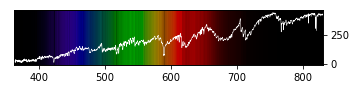
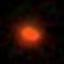
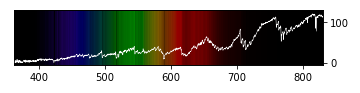
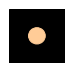
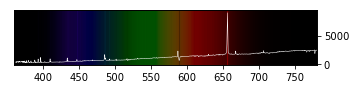

Prediction distance - K above target Teff
               0
38  -1712.532760
191 -1214.091504
226 -1149.418322
790 -1124.086525
954 -1114.121065


MANGAID,Image,Spectrum,Input T,Input source
3-9804335,,,6256K,LAMOST
3-142072281,,,3926K,OLDAPOGEE
60-598960436699728256,,,4119K,OLDAPOGEE
3-113122000,,,6342K,SEGUE
3-153223917,,,5154K,LAMOST

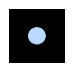
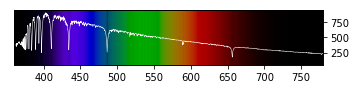
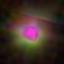
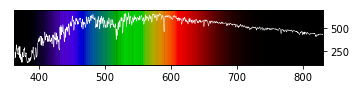
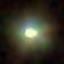
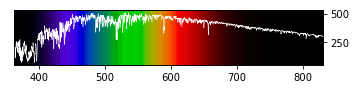
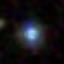
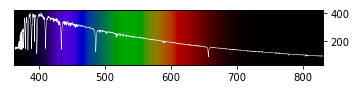
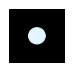
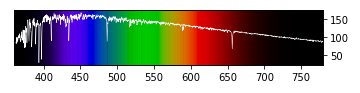

In [39]:
prediction_too_cold = pd.DataFrame(residuals).sort_values(0, ascending=False).head(n=5)
prediction_too_hot = pd.DataFrame(residuals).sort_values(0, ascending=True).head(n=5)

display(HTML('<h2>Prediction too cold</h2>'))
print('Prediction distance - K below target Teff')
print(prediction_too_cold)
o = ''
for tc in prediction_too_cold.index:
    id = mangaid_testing.iloc[tc]
    s = sl.get_star(id)
    o += s.get_table_line()
display(HTML(sl.wrap_in_table(o)))

display(HTML('<h2>Prediction too hot</h2>'))
print('Prediction distance - K above target Teff')
print(prediction_too_hot)
o = ''
for tc in prediction_too_hot.index:
    id = mangaid_testing.iloc[tc]
    s = sl.get_star(id)
    o += s.get_table_line()
display(HTML(sl.wrap_in_table(o)))

The top two "too cold" predictions can be attributed to bad data - spectrogram is cut off (which is probably due to mask or ivar processing). The next two I think can be attributed to "bad catalogued Teff" - the spectrum looks like other dim red stars, and comparing temperatures to the ones we've seen in 02, the teff of 5,000K+ seems excessive.

The last "too cold" example (7-13115756) seems like an outlier - there is a very strong peak of infra-red at around 650-660nm with an unusual flux value of 10,000, and also many other less pronounced peaks. No other spectrum I've seen so far in this dataset has such peaks instead of the usual absorption dips, and especially not of this magnitude. This makes me think either the spectrum was flipped by mistake, or there was equipment issues. 

The first and fourth "too hot" stars also seem like "bad catalogued Teff" - spectrum looks like a usual hot blue star, and I'd expect the Teff to be around 8,000K. Similar with  second and third: this kind of whitish star seems to usually be around 6,000K, but here the Teff is much lower. Similarly with the fifth star - it's a blue-ish star (more blue than white), and these tend to be in the 6,000K range.

Note the "bad catalogued Teff" label might well be me not understanding enough about spectral behaviour of stars to pick some special characteristics of these "bad" stars.

Overall, since in most of the cases we can figure out why the model would make the prediction it made, I think this is a sign of the model resilience. 

Quick peek at the odd 7-13115756 star:

7-13115756


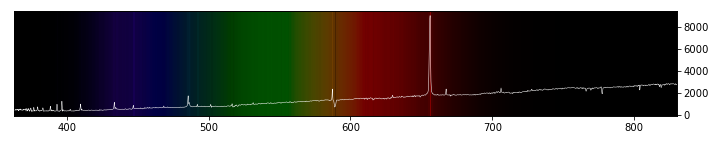

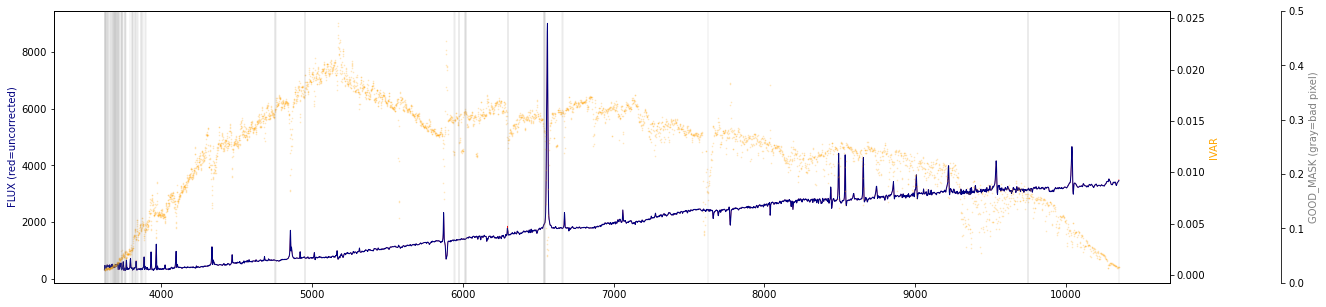

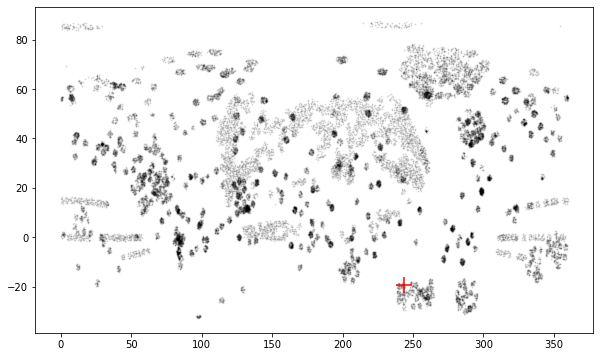

<SkyCoord (ICRS): (ra, dec) in deg
    ( 243.934217, -19.354803)>


In [40]:
s = sl.get_star('7-13115756')
print(s.get_mangaid())
s.show_spectrum_strip()
s.show_spectrum()
sl.locate_star(s)
print(s.get_coord())

Looking at [simbad catalogue](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=243.93+-19.35&submit=SIMBAD+search), there is a [star](http://simbad.cds.unistra.fr/simbad/sim-id?Ident=%402529436&Name=GSC%2006209-00747&submit=submit) at this location in the sky - and it turns out to be an "emission-line star" ([2MASS](https://irsa.ipac.caltech.edu/workspace/TMP_o12vyF_24242/Gator/irsa/4642/tbview.html)). The model is confused by this star probably because it hasn't seen enough of these to start recognising them - normally there would be a hydrogen absorption line at 660nm, but here there is an emission line instead!